# CS4220 Project 2 Random Forest Approach

## Installs, Imports and Config

In [2]:
import os
import time

import numpy as np
import pandas as pd

import pickle as pkl
from zipfile import ZipFile

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

## Google Drive Connection

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
HOME = 'gdrive/MyDrive/CS4220_P2/'

In [4]:
os.listdir(HOME)

['validation-20220321T132526Z-001.zip',
 'validation',
 'rf.pkl',
 'rf_2.pkl',
 'updated_rf.pkl',
 'updated_rf_2.pkl',
 'updated_rf_threshold.pkl',
 'labels.csv',
 'perfect_reads_6mer.gz']

## Load Training Labels

In [5]:
df_y = pd.read_csv(HOME+'labels.csv')
df_y['genome_name'].value_counts()

decoy                          815912
burkholderia_pseudomallei        8558
pseudomonas_aeruginosa           7568
mycobacterium_ulcerans           6786
mycobacterium_tuberculosis       5265
staphylococcus_aureus            3412
corynebacterium_ulcerans         2962
corynebacterium_diphtheriae      2885
neisseria_gonorrhoeae            2637
streptococcus_pneumoniae         2600
staphylococcus_pyogenes          2078
Name: genome_name, dtype: int64

In [6]:
for i in range((len(df_y)//100000)+1):
  start = 100000*i
  end = 100000*(i+1)
  temp = df_y.iloc[start:end,:]['genome_name']
  print(temp.value_counts())

decoy                          55249
burkholderia_pseudomallei       8558
pseudomonas_aeruginosa          7568
mycobacterium_ulcerans          6786
mycobacterium_tuberculosis      5265
staphylococcus_aureus           3412
corynebacterium_ulcerans        2962
corynebacterium_diphtheriae     2885
neisseria_gonorrhoeae           2637
streptococcus_pneumoniae        2600
staphylococcus_pyogenes         2078
Name: genome_name, dtype: int64
decoy    100000
Name: genome_name, dtype: int64
decoy    100000
Name: genome_name, dtype: int64
decoy    100000
Name: genome_name, dtype: int64
decoy    100000
Name: genome_name, dtype: int64
decoy    100000
Name: genome_name, dtype: int64
decoy    100000
Name: genome_name, dtype: int64
decoy    100000
Name: genome_name, dtype: int64
decoy    60663
Name: genome_name, dtype: int64


In [7]:
le = preprocessing.LabelEncoder()
le.fit(df_y['genome_name'].unique())
y_index = le.transform(df_y['genome_name'].values)
y_true = y_index[:100000]

In [8]:
np.bincount(y_true)

array([ 8558,  2885,  2962, 55249,  5265,  6786,  2637,  7568,  3412,
        2078,  2600])

In [10]:
for i in range(len(le.classes_)):
  print(f'{i}: {le.classes_[i]}')

0: burkholderia_pseudomallei
1: corynebacterium_diphtheriae
2: corynebacterium_ulcerans
3: decoy
4: mycobacterium_tuberculosis
5: mycobacterium_ulcerans
6: neisseria_gonorrhoeae
7: pseudomonas_aeruginosa
8: staphylococcus_aureus
9: staphylococcus_pyogenes
10: streptococcus_pneumoniae


## Load Training DataFrame

In [11]:
df = pd.read_csv(HOME+'perfect_reads_6mer.gz', header=None, sep='\t', nrows=100000)

In [12]:
df.fillna(-1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080
0,0.003247,0.002165,0.002165,0.000000,0.004329,0.002165,0.001082,0.000000,0.001082,0.001082,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,0.006237,0.004158,0.001040,0.002079,0.003119,0.003119,0.004158,0.001040,0.004158,0.000000,...,0.002079,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,0.004261,0.002841,0.001420,0.004261,0.005682,0.007102,0.005682,0.002841,0.001420,0.002841,...,0.000000,0.00142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
3,0.000000,0.001528,0.002293,0.001146,0.001911,0.001911,0.000764,0.001528,0.003439,0.001911,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,0.001919,0.003838,0.001679,0.002399,0.003838,0.002878,0.001919,0.002399,0.002399,0.001199,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


## Fit Initial RF Important Features

In [13]:
clf = RandomForestClassifier(random_state = 42)
clf.fit(df, y_true)

RandomForestClassifier(random_state=42)

In [ ]:
# with open(HOME+'rf.pkl', 'wb') as handle:
#     pkl.dump(clf, handle, protocol=pkl.HIGHEST_PROTOCOL)

# clf = None
# with open(HOME+'rf.pkl', 'rb') as handle:
#     clf = pkl.load(handle)

In [14]:
imps = list(enumerate(clf.feature_importances_))
imps.sort(key=lambda x: x[1], reverse=True)
rf_imps = imps[:150]

In [15]:
# rf_features = [x[0] for x in rf_imps]
# Original ones
rf_features = [1927, 1517, 2070, 1917, 1404, 1922, 2069, 1939, 1913, 852, 1864, 1934, 1985, 1374, 2032, 689, 1926, 1643, 1903, 2050, 1940, 1921, 1925, 1923, 1847, 1509, 1924, 1869, 2067, 1863, 2042, 1930, 1908, 1524, 2063, 1516, 645, 1773, 2065, 2073, 1885, 1218, 469, 688, 251, 1630, 1515, 1091, 1868, 1999, 466, 1867, 1865, 2057, 1889, 2001, 1534, 2064, 1866, 685, 1518, 1666, 813, 1631, 1919, 2061, 1938, 1392, 1911, 2, 1491, 1660, 1859, 1613, 1720, 2000, 2058, 1904, 909, 658, 1996, 891, 1890, 2046, 864, 1, 889, 863, 816, 1665, 841, 1249, 2077, 1500, 648, 1774, 234, 1376, 1635, 1411, 69, 1958, 1942, 1860, 1884, 1499, 1577, 2048, 1641, 897, 1394, 1819, 1525, 1915, 857, 214, 378, 2030, 1756, 1216, 1490, 2079, 753, 2049, 1356, 1532, 1251, 1936, 849, 311, 185, 1830, 1492, 1622, 1279, 634, 1285, 1187, 1148, 2055, 564, 1633, 1373, 1412, 1600, 1772, 1295, 2035, 1354, 1542]
# Updated
# rf_features = [1517, 2069, 1934, 1930, 1922, 1864, 852, 1925, 1917, 1927, 2070, 1908, 2050, 1867, 1404, 2032, 2064, 1866, 1913, 2073, 2042, 1999, 469, 1643, 1773, 1863, 1985, 645, 658, 2067, 1889, 2030, 1518, 1903, 1509, 1524, 2057, 849, 2, 1926, 1249, 2076, 688, 2061, 1, 17, 1868, 1921, 2001, 1939, 634, 2046, 1940, 1942, 1091, 1865, 1919, 1884, 1819, 2063, 1150, 1824, 753, 1516, 311, 1412, 1510, 1986, 905, 251, 891, 863, 1394, 897, 234, 65, 1149, 1376, 1859, 1492, 5, 875, 69, 1869, 2065, 2048, 1534, 1156, 1890, 1148, 1943, 814, 1774, 1251, 3, 81, 2058, 326, 330, 214, 1491, 1354, 1500, 2000, 1830, 2078, 329, 1201, 1936, 312, 854, 1772, 1666, 648, 1254, 6, 909, 1525, 1756, 1218, 1923, 1862, 1924, 1392, 1166, 597, 1910, 66, 63, 1499, 1375, 7, 888, 13, 908, 1638, 128, 1938, 485, 889, 33, 1187, 1668, 689, 1094, 8, 1847, 1883, 851, 2079]
# Even Split
# rf_features = [1517, 2069, 1934, 1930, 1922, 1864, 852, 1925, 1917, 1927, 2070, 1908, 2050, 1867, 1404, 2032, 2064, 1866, 1913, 2073, 2042, 1999, 469, 1643, 1773, 1863, 1985, 645, 658, 2067, 1889, 2030, 1518, 1903, 1509, 1524, 2057, 849, 2, 1926, 1249, 2076, 688, 2061, 1, 17, 1868, 1921, 2001, 1939, 634, 2046, 1940, 1942, 1091, 1865, 1919, 1884, 1819, 2063, 1150, 1824, 753, 1516, 311, 1412, 1510, 1986, 905, 251, 891, 863, 1394, 897, 234, 65, 1149, 1376, 1859, 1492, 5, 875, 69, 1869, 2065, 2048, 1534, 1156, 1890, 1148, 1943, 814, 1774, 1251, 3, 81, 2058, 326, 330, 214, 1491, 1354, 1500, 2000, 1830, 2078, 329, 1201, 1936, 312, 854, 1772, 1666, 648, 1254, 6, 909, 1525, 1756, 1218, 1923, 1862, 1924, 1392, 1166, 597, 1910, 66, 63, 1499, 1375, 7, 888, 13, 908, 1638, 128, 1938, 485, 889, 33, 1187, 1668, 689, 1094, 8, 1847, 1883, 851, 2079]
# Even Organisms, Large decoy
# rf_features = [1517, 2070, 1927, 1922, 1925, 1917, 1926, 1864, 1934, 2069, 1930, 2050, 2064, 1863, 1939, 1509, 1, 2042, 1166, 1869, 1518, 1524, 1404, 1913, 1218, 2032, 1091, 2067, 1923, 689, 1938, 1773, 2001, 1903, 1921, 1376, 1940, 469, 905, 852, 1985, 1110, 16, 1889, 2073, 841, 1908, 1249, 2076, 658, 1412, 4, 1866, 2057, 69, 1868, 2063, 1149, 988, 917, 326, 1943, 1148, 1254, 1516, 1665, 1622, 2058, 1549, 1152, 2, 251, 1534, 1185, 1492, 2065, 29, 857, 17, 1915, 1756, 1919, 1830, 840, 1420, 63, 1411, 2034, 1168, 1867, 33, 1187, 1374, 1392, 1643, 466, 297, 688, 252, 1924, 21, 814, 330, 596, 909, 908, 1167, 1541, 2030, 1491, 1819, 1111, 429, 1958, 1510, 1094, 1865, 1942, 77, 158, 1772, 891, 645, 81, 965, 322, 1812, 1155, 1500, 1817, 66, 871, 1251, 1613, 1150, 1884, 1660, 100, 962, 1298, 311, 1862, 2061, 171, 1912, 329, 1595, 214, 685, 1202]
print(rf_features)

[1927, 1517, 2070, 1917, 1404, 1922, 2069, 1939, 1913, 852, 1864, 1934, 1985, 1374, 2032, 689, 1926, 1643, 1903, 2050, 1940, 1921, 1925, 1923, 1847, 1509, 1924, 1869, 2067, 1863, 2042, 1930, 1908, 1524, 2063, 1516, 645, 1773, 2065, 2073, 1885, 1218, 469, 688, 251, 1630, 1515, 1091, 1868, 1999, 466, 1867, 1865, 2057, 1889, 2001, 1534, 2064, 1866, 685, 1518, 1666, 813, 1631, 1919, 2061, 1938, 1392, 1911, 2, 1491, 1660, 1859, 1613, 1720, 2000, 2058, 1904, 909, 658, 1996, 891, 1890, 2046, 864, 1, 889, 863, 816, 1665, 841, 1249, 2077, 1500, 648, 1774, 234, 1376, 1635, 1411, 69, 1958, 1942, 1860, 1884, 1499, 1577, 2048, 1641, 897, 1394, 1819, 1525, 1915, 857, 214, 378, 2030, 1756, 1216, 1490, 2079, 753, 2049, 1356, 1532, 1251, 1936, 849, 311, 185, 1830, 1492, 1622, 1279, 634, 1285, 1187, 1148, 2055, 564, 1633, 1373, 1412, 1600, 1772, 1295, 2035, 1354, 1542]


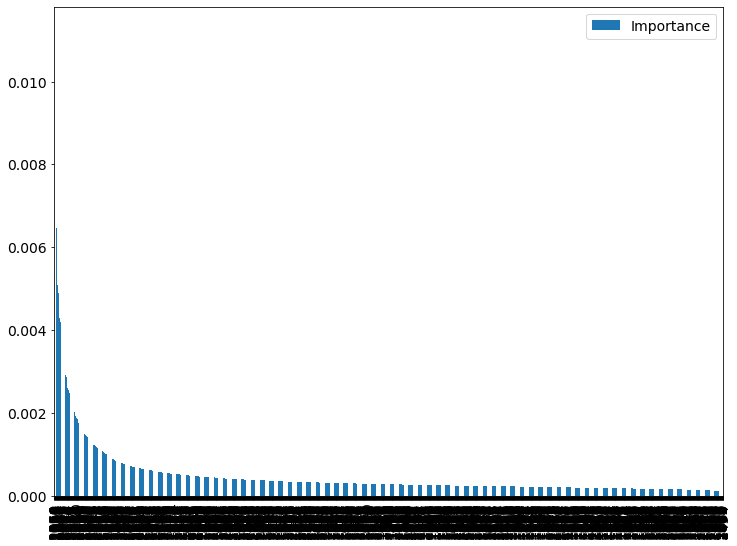

In [20]:
feat_importances = pd.DataFrame(clf.feature_importances_, index=df.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(12,9))

## Main RF Classifier

In [21]:
clf2 = RandomForestClassifier(random_state = 42)
clf2.fit(df[rf_features], y_true)

RandomForestClassifier(random_state=42)

In [ ]:
# with open(HOME+'rf2.pkl', 'wb') as handle:
#     pkl.dump(clf2, handle, protocol=pkl.HIGHEST_PROTOCOL)

# clf2 = None
# with open(HOME+'rf2.pkl', 'rb') as handle:
#     clf2 = pkl.load(handle)

## Validation

In [22]:
def precision_per_patient(patient_id, preds):
    df_true = pd.read_csv(f'{HOME}validation/val{patient_id}_labels.txt')
    tp, fp=0,0
    print(f'my predition(s) for patient {patient_id}:')
    print(preds)
    print('true pathogen')
    print(df_true['true_label'].values)
    for item in np.unique(preds):
        if item in df_true['true_label'].values:
            tp+=1
        else:
            fp+=1
    return tp/(tp+fp)

In [23]:
idx = pd.MultiIndex.from_product([[f'Patient_{i}' for i in range(1, 17)]+[f'Train_{i}' for i in range(1,9)],
                                  ['Abundance', 'Pred_prob']],
                                 names=['Brand', 'Metric'])
res_df = pd.DataFrame(columns = list(le.classes_), index=idx)

In [24]:
#prediction for all patients
threshold = 0.7

for patient_id in range(1,9):
    print(f'predicting for train {patient_id}')
    df_test = pd.read_csv(HOME+'perfect_reads_6mer.gz', header=None, sep='\t', nrows=100000, skiprows=(patient_id*100000))
    df_test.fillna(-1, inplace=True)
    y_pred = clf2.predict(df_test[rf_features])
    y_predprob = clf2.predict_proba(df_test[rf_features])
    #we get only predictions larger than the threshold and if there is more than one, we take the argmax again
    final_predictions = le.inverse_transform(np.unique([np.argmax(item) for item in y_predprob  if len(np.where(item>= threshold)[0]) >=1]))
    prob_list = pd.DataFrame([np.argmax(item) for item in y_predprob  if len(np.where(item>= threshold)[0]) >=1]).value_counts()
    prob_dict = prob_list.apply(lambda x: x/sum(prob_list)).to_dict()
    per_df = pd.DataFrame(y_pred).value_counts().apply(lambda x: x/len(y_pred))
    pred_dict = (per_df.to_dict())
    # print(pred_dict)
    res_df.loc[(f'Train_{patient_id}','Abundance'), 'decoy'] = 1.0
    for key in prob_dict.keys():
      res_df.loc[(f'Train_{patient_id}', 'Pred_prob'), list(le.classes_)[key[0]]] = prob_dict[key]

predicting for train 1
predicting for train 2
predicting for train 3
predicting for train 4
predicting for train 5
predicting for train 6
predicting for train 7
predicting for train 8


In [26]:
#prediction for all patients
threshold = 0.7

all_precision = []
for patient_id in range(1, 17):
    print(f'predicting for patient {patient_id}')
    a_df = None
    if(patient_id < 11):
      a_df = pd.read_csv(f'{HOME}validation/val{patient_id}_abundance.txt', header=None, sep=' ', index_col=0)
      a_dict = a_df.to_dict()[1]
    else:
      a_df = pd.read_csv(f'{HOME}validation/val{patient_id}_labels.txt')
      a_dict = {}
      vals = a_df.to_dict()['true_label'].values()
      for val in vals:
        a_dict[val] = 1
    df_test = pd.read_csv(f'{HOME}validation/val{patient_id}_6mer.gz', header=None, sep='\t')
    #we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
    #here I apply 0.999 as the cutoff for my predictions, let's see how well my model will behave...
    y_predprob = clf2.predict_proba(df_test[rf_features])
    # y_predprob = clf.predict_proba(df_test.fillna(-1))
    #we get only predictions larger than the threshold and if there is more than one, we take the argmax again
    final_predictions = le.inverse_transform(np.unique([np.argmax(item) for item in y_predprob  if len(np.where(item>= threshold)[0]) >=1]))
    prob_list = pd.DataFrame([np.argmax(item) for item in y_predprob  if len(np.where(item>= threshold)[0]) >=1]).value_counts()
    prob_dict = prob_list.apply(lambda x: x/sum(prob_list)).to_dict()
    # print(pred_dict)
    for key in prob_dict.keys():
      res_df.loc[(f'Patient_{patient_id}', 'Pred_prob'), list(le.classes_)[key[0]]] = prob_dict[key]
    for key in a_dict.keys():
      res_df.loc[(f'Patient_{patient_id}','Abundance'), key] = a_dict[key]
    # print(res_df)
    #my pathogens dectected, decoy will be ignored
    without_decoy = [item for item in final_predictions if item !='decoy']
    if(len(without_decoy) == 0):
      pass
    else:
      vals = res_df.loc[(f'Patient_{patient_id}', 'Pred_prob'),]
      temp_dict = {}
      for item in without_decoy:
        temp_dict[item] = vals[item]
      temp_dict = {k: v for k, v in sorted(temp_dict.items(), key=lambda item: -item[1])}
      print(temp_dict)
      res_o = []
      for key in temp_dict:
        if(len(res_o) == 0):
          res_o.append(key)
        else:
          if(temp_dict[key] > (temp_dict[res_o[0]]/10.0)):
            res_o.append(key)
      final_predictions = res_o#without_decoy
    try:
      precision = precision_per_patient(patient_id, final_predictions)
    except:
      precision = 0
    print('precision: {}'.format(precision))
    all_precision.append(precision)

predicting for patient 1
{'staphylococcus_aureus': 0.0012656043260656964}
my predition(s) for patient 1:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
precision: 1.0
predicting for patient 2
{'staphylococcus_pyogenes': 0.00011304544426859598}
my predition(s) for patient 2:
['staphylococcus_pyogenes']
true pathogen
['staphylococcus_pyogenes']
precision: 1.0
predicting for patient 3
{'burkholderia_pseudomallei': 0.0028459821428571427, 'corynebacterium_ulcerans': 0.00078125}
my predition(s) for patient 3:
['burkholderia_pseudomallei', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
precision: 1.0
predicting for patient 4
my predition(s) for patient 4:
['decoy']
true pathogen
['pseudomonas_aeruginosa']
precision: 0.0
predicting for patient 5
{'corynebacterium_diphtheriae': 0.011849592303631137, 'corynebacterium_ulcerans': 0.00011732269607555581}
my predition(s) for patient 5:
['corynebacterium_diphtheriae']
true pathoge

In [27]:
res_df

burkholderia_pseudomallei corynebacterium_diphtheriae  \
Brand      Metric                                                            
Patient_1  Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_2  Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_3  Abundance                  0.003333                         NaN   
           Pred_prob                  0.002846                         NaN   
Patient_4  Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_5  Abundance                       NaN                    0.068833   
           Pred_prob                       NaN                     0.01185   
Patient_6  Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_7  Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_8  Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_9  Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_10 Abundance                  0.045671                         NaN   
           Pred_prob                  0.040246                         NaN   
Patient_11 Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_12 Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_13 Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_14 Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Patient_15 Abundance                         1                           1   
           Pred_prob                  0.039273                     0.00077   
Patient_16 Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Train_1    Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Train_2    Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Train_3    Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Train_4    Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Train_5    Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Train_6    Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Train_7    Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   
Train_8    Abundance                       NaN                         NaN   
           Pred_prob                       NaN                         NaN   

                     corynebacterium_ulcerans     decoy  \
Brand      Metric                                         
Pa

In [28]:
res_df.fillna(0, inplace=True)
res_df.to_csv('results_new.csv')

In [29]:
#performance per patient and its final average
print([f'patient {c}: {item}' for c, item in enumerate(all_precision, start=1)], f'avg: {np.mean(all_precision)}')

['patient 1: 1.0', 'patient 2: 1.0', 'patient 3: 1.0', 'patient 4: 0.0', 'patient 5: 1.0', 'patient 6: 1.0', 'patient 7: 1.0', 'patient 8: 1.0', 'patient 9: 1.0', 'patient 10: 1.0', 'patient 11: 1.0', 'patient 12: 1.0', 'patient 13: 1.0', 'patient 14: 1.0', 'patient 15: 1.0', 'patient 16: 1.0'] avg: 0.9375
